In [1]:
import cv2
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
mmscaler = MinMaxScaler()
sdscaler = StandardScaler()
from functools import partial
from collections import Counter
from collections import namedtuple
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
import math
from sklearn.cluster import KMeans, AffinityPropagation, estimate_bandwidth, MeanShift, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
round_3 = partial(round, ndigits=3)

In [2]:
color_list = ['lightcoral', 'orangered', 'olive', 'dodgerblue', 'palegreen', 'gold', 'peachpuff', 'grey', 'red', 'mediumorchid', 'thistle', 'darkviolet', 'purple', 'cyan', 'deepskyblue', 'lavender', 'blue']

In [52]:
dd = pd.read_pickle("/home/hb/python/phospho/data/required/0308_final_train_test/dataset3.pkl")
true_set = np.array([x for x in dd[dd['answer']==1].pair])
kinmap = pd.read_csv("../kinase_family_kinmap.csv")
df = pd.read_pickle("grad_cam_result.pkl")
del df['grad_cam'], df['grad_cam_pp']
df = df[df['pair'].isin(true_set)].reset_index(drop=True)
ind_kinase = pd.DataFrame(df.kinase.value_counts())
ind_kinase_up9 = ind_kinase[ind_kinase['kinase']>9]
famdict = {_name: _family for _name, _family in zip(kinmap['xName'], kinmap['Family'])}
# dff = df[['kinase', 'family']]
df = df[df['kinase'].isin(ind_kinase_up9.index)].reset_index(drop=True)
df.head(2)

,pair,kinase,uniprotID,substrate,family,group,gradcam_resize,gradcam_pp_resize,flatten_gradcam
0,Q9UM73_VVACNLYPFVKTV,ALK,Q9UM73,VVACNLYPFVKTV,ALK,TK,"[[0.0, 0.0002912359, 0.0002912359, 0.0, 0.0, 0...","[[0.078041434, 0.19234952, 0.19234952, 0.0, 0....","[0.0, 0.0002912359, 0.0002912359, 0.0, 0.0, 0...."
1,Q9UM73_EDSARVYENVGLM,ALK,Q9UM73,EDSARVYENVGLM,ALK,TK,"[[0.0, 0.0011268717, 0.0007289335, 0.000696246...","[[0.0, 0.22309835, 0.027849337, 0.04644754, 0....","[0.0, 0.0011268717, 0.0007289335, 0.0006962465..."


In [56]:
# 몇 개 이상의 하위 개별 kinase를 포함하는 것만 뽑을지 정하는 코드

def make_family_count_dict(count:int):
    dff = df[['kinase', 'family']]
    dfff = pd.DataFrame(dff.groupby('family')['kinase'].value_counts())
    family_counts_dict = {}
    for x in [x[0] for x in dfff.index]:
        if x not in family_counts_dict.keys():
            family_counts_dict[x] = 1
        else:
            family_counts_dict[x] += 1
    tt = [(x, y) for x, y in family_counts_dict.items()]
    for _family, _count in tt:
        if _count < count:
            del family_counts_dict[_family]

    df_up = df[df['family'].isin(family_counts_dict.keys())].reset_index(drop=True)
    return family_counts_dict, df_up

In [57]:
# 정규화, 표준화

def normalization(df, base_column:str):
    
    flatten_gradcam = np.array([x for x in df[base_column]])
    flatten_gradcam_mm = mmscaler.fit_transform(flatten_gradcam)
    flatten_gradcam_sd = sdscaler.fit_transform(flatten_gradcam)

    flatten_gradcam_mm = [x for x in flatten_gradcam_mm]
    df['avg_gradcam_mm_bavg'] = flatten_gradcam_mm

    flatten_gradcam_sd = [x for x in flatten_gradcam_sd]
    df['avg_gradcam_sd_bavg'] = flatten_gradcam_sd

    family_gradcam = df.groupby("kinase").mean()

    minmax_gradcam = mmscaler.fit_transform([x for x in family_gradcam[base_column]])
    standard_gradcam = sdscaler.fit_transform([x for x in family_gradcam[base_column]])

    family_gradcam['avg_gradcam_mm_aavg'] = [x for x in minmax_gradcam]
    family_gradcam['avg_gradcam_sd_aavg'] = [x for x in standard_gradcam]
    family_gradcam['counts'] = df.kinase.value_counts(sort=False)

    origin_gradcam = family_gradcam[base_column]
    minmax_gradcam_aavg = family_gradcam['avg_gradcam_mm_aavg']
    standard_gradcam_aavg = family_gradcam['avg_gradcam_sd_aavg']
    minmax_gradcam_bavg = family_gradcam['avg_gradcam_mm_bavg']
    standard_gradcam_bavg = family_gradcam['avg_gradcam_sd_bavg']
    family_gradcam['family'] = [famdict[i] if i in famdict.keys() else None for i in family_gradcam.index ]

    CorMatrix = namedtuple("CorMatrix", [base_column, 'avg_gc_mm_bavg', 'avg_gc_sd_bavg', 'avg_gc_mm_aavg', 'avg_gc_sd_aavg'])

    # corr_matrix = CorMatrix()
    def make_cor_matrix(df):
        grad_cam_mean = pd.DataFrame([df[x] for x in df.index], index=df.index)
        grad_cam_mean = grad_cam_mean.T
        grad_cam_mean_corr = grad_cam_mean.corr()
        return grad_cam_mean_corr

    corr_matrix_dict = {}
    for i in [origin_gradcam, minmax_gradcam_aavg, standard_gradcam_aavg, minmax_gradcam_bavg, standard_gradcam_bavg]:
        print(i.name)
        corr_matrix_dict[i.name] = make_cor_matrix(i)
        # corr_matrix.append(make_cor_matrix(i))
    # corr_matrix_dict = {i.name: i for i in corr_matrix}
    # corr_matrix = CorMatrix(*corr_matrix)
    corr_matrix_dict['family_gradcam'] = family_gradcam
    
    return corr_matrix_dict

In [58]:
def calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels, threshold):

    _num_clusters = len(set(labels))
    _silhouette_score = round_3(silhouette_score(distance_matrix, labels, metric='euclidean'))
    _calinski_harabasz_score = round_3(calinski_harabasz_score(distance_matrix, labels))
    _davies_bouldin_score = round_3(davies_bouldin_score(distance_matrix, labels))
    ari = round_3(adjusted_rand_score(true_labels, labels))
    ami = round_3(adjusted_mutual_info_score(true_labels, labels))
    _result = [threshold, SCAILING_METHOD, CLUSTERING_METHOD, _num_clusters, _silhouette_score, _calinski_harabasz_score, _davies_bouldin_score, ari, ami]
    _result = pd.DataFrame([_result], columns=['threshold', 'scaling', 'clustering', 'num_clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', "AMI"])
    return _result

In [59]:
def make_clustering_result(threshold, SCAILING_METHOD, distance_matrix, clustering_result, max_clusters:int):
    
    CLUSTERING_METHOD = 'KMeans'
    # print(f'{CLUSTERING_METHOD} START!')
    for i in range(2, max_clusters+1):

        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(distance_matrix)
        labels = kmeans.labels_
        _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels, threshold)

        clustering_result = pd.concat([clustering_result, _result], axis=0)

    clustering_result = clustering_result.dropna().reset_index(drop=True)
        
    CLUSTERING_METHOD = 'AffinityPropagation'
    # print(f'{CLUSTERING_METHOD} START!')
    for pref in range(-80, -1, 5):
        try:
            affinityPropagation = AffinityPropagation(preference=pref, random_state=0)
            affinityPropagation.fit(distance_matrix)
            labels = affinityPropagation.labels_
            if len(set(labels)) <= max_clusters:
                _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels, threshold)
        except:
            pass
        if type(_result) == pd.core.frame.DataFrame:
            clustering_result = pd.concat([clustering_result, _result], axis=0)

    clustering_result = clustering_result.dropna().reset_index(drop=True)

    CLUSTERING_METHOD = 'MeanShift'
    # print(f'{CLUSTERING_METHOD} START!')
    for bandwith in np.arange(0.1, 2.5, 0.1): 
        try:
            meanshift = MeanShift(bandwidth=bandwith, n_jobs=64)
            meanshift.fit(distance_matrix)
            labels = meanshift.labels_
            if len(set(labels)) <= max_clusters:
                _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels, threshold)
                clustering_result = pd.concat([clustering_result, _result], axis=0)
        except:
            pass
    clustering_result = clustering_result.dropna().reset_index(drop=True)

    CLUSTERING_METHOD = 'SpectralClustering'
    # print(f'{CLUSTERING_METHOD} START!')
    for i in range(2, max_clusters+1):
        
        spectralClustering = SpectralClustering(n_clusters=i, n_init=10, random_state=0, n_jobs=64)
        spectralClustering.fit(distance_matrix)
        labels = spectralClustering.labels_
        _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels, threshold)
        clustering_result = pd.concat([clustering_result, _result], axis=0) 
    clustering_result = clustering_result.dropna().reset_index(drop=True)

    for LINKAGE_METHOD in ['ward', 'complete', 'average', 'single']:
        CLUSTERING_METHOD = f'Agglomerative_{LINKAGE_METHOD}'
        # print(f'{CLUSTERING_METHOD} START!')
        for i in range(2, max_clusters+1):

            # cluster_labels = labels
            agglomerativeClustering = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=LINKAGE_METHOD)
            agglomerativeClustering.fit(distance_matrix)
            labels = agglomerativeClustering.labels_
            _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels, threshold)
            clustering_result = pd.concat([clustering_result, _result], axis=0) 
    clustering_result = clustering_result.dropna().reset_index(drop=True)

    return clustering_result

In [66]:
total_family_count_dict = {}
total_df = {}
for _count in [3, 4, 5]:
    total_family_count_dict[f'{_count}'], total_df[f'{_count}'] = make_family_count_dict(_count)
total_corr_matrix_dict = {}
for _count, df in total_df.items():
    total_corr_matrix_dict[f'{_count}'] = normalization(df, 'flatten_gradcam')

flatten_gradcam
avg_gradcam_mm_aavg
avg_gradcam_sd_aavg
avg_gradcam_mm_bavg
avg_gradcam_sd_bavg
flatten_gradcam
avg_gradcam_mm_aavg
avg_gradcam_sd_aavg
avg_gradcam_mm_bavg
avg_gradcam_sd_bavg
flatten_gradcam
avg_gradcam_mm_aavg
avg_gradcam_sd_aavg
avg_gradcam_mm_bavg
avg_gradcam_sd_bavg


In [12]:
corr_matrix_dict = total_corr_matrix_dict['3']
# Adjusted Rand Index (ARI)
# Adjusted Mutual Information (AMI)

clustering_result = pd.DataFrame(columns=['threshold', 'scaling', 'clustering', 'num_clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', 'AMI'])

cormatrix = corr_matrix_dict['avg_gradcam_sd_aavg']
distance_matrix = 1 - cormatrix
cormatrix_family = [famdict[x] for x in cormatrix.index]
encoder = LabelEncoder()
true_labels = encoder.fit_transform(cormatrix_family)
true_labels 

array([ 1,  1,  5,  5, 12, 11, 12,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,
        3,  3,  3,  0,  0,  0,  4,  4,  4,  7,  7,  7,  7, 11, 11,  5,  5,
       11,  4,  6,  6,  6,  8, 12,  7,  7,  7, 11,  1, 11,  1,  1,  1,  1,
        8, 10, 10, 10,  7,  1, 10, 10, 10, 10, 10,  2,  9,  9,  9,  9,  1,
        5,  1, 11, 10,  8,  6, 12, 11,  7,  7,  7,  7])

In [70]:
clustering_result = pd.DataFrame(columns=['threshold', 'scaling', 'clustering', 'num_clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', 'AMI'])

for threshold, corr_matrix_dict in total_corr_matrix_dict.items():
    print(threshold)
    for scailing, cormatrix in corr_matrix_dict.items():
        print(scailing)
        if scailing != 'family_gradcam':
            nas = [x for x in cormatrix[cormatrix.iloc[1].isnull()].index]
            try:
                cormatrix.drop(nas, axis=0, inplace=True)
                cormatrix.drop(nas, axis=1, inplace=True)
            except:
                continue
            distance_matrix = 1 - cormatrix
            cormatrix_family = [famdict[x] for x in cormatrix.index]
            encoder = LabelEncoder()
            true_labels = encoder.fit_transform(cormatrix_family)
            
            clustering_result = make_clustering_result(threshold, scailing, distance_matrix, clustering_result, len(set(true_labels)))

3
flatten_gradcam
avg_gradcam_mm_aavg
avg_gradcam_sd_aavg
avg_gradcam_mm_bavg
avg_gradcam_sd_bavg
family_gradcam
4
flatten_gradcam
avg_gradcam_mm_aavg
avg_gradcam_sd_aavg
avg_gradcam_mm_bavg
avg_gradcam_sd_bavg
family_gradcam
5
flatten_gradcam
avg_gradcam_mm_aavg
avg_gradcam_sd_aavg
avg_gradcam_mm_bavg
avg_gradcam_sd_bavg
family_gradcam


In [76]:
clustering_result.to_csv("0703_gcpp_clustering_result.csv")

In [72]:
scaler = mmscaler.fit_transform(clustering_result[['silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', 'AMI']])
clustering_result[['silhouette', 'calinski_harabasz', 'davies_bouldin', 'ARI', 'AMI']] = scaler

In [73]:
clustering_result.to_csv('0704_gc_norm_clustering_result.csv', index=False)

In [91]:
# i = 6
# LINKAGE_METHOD = 'average'
# clustering = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=LINKAGE_METHOD).fit(distance_matrix)

# labels = clustering.labels_

In [51]:
# predict = pd.DataFrame(fcluster(clustermap.dendrogram_col.linkage, 4.3, criterion='distance'))
# predict.columns=['predict']
# ct = pd.crosstab(predict['predict'], cormatrix.index)
# ct = ct.T
# cluster_family_dict_ = {}

# for i in range(1, len(ct.columns)+1):
    
#     _cluster = ct[i]
#     _cluster_kinase = _cluster.loc[_cluster==1].index.tolist()
#     _cluster_family = [famdict[x] for x in _cluster_kinase]
#     cluster_family_dict_[f'cluster{i}'] = _cluster_family
#     print(f'cluster{i}:{_cluster_kinase}')
#     # print(_cluster_kinase)
#     print('=='*20)
# len(cluster_family_dict_.keys())

In [ ]:

    for LINKAGE_METHOD in ['ward', 'complete', 'average', 'single']:
        CLUSTERING_METHOD = f'Agglomerative_{LINKAGE_METHOD}'
        # print(f'{CLUSTERING_METHOD} START!')
        for i in range(2, max_clusters+1):

            # cluster_labels = labels
            agglomerativeClustering = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=LINKAGE_METHOD)
            agglomerativeClustering.fit(distance_matrix)
            labels = agglomerativeClustering.labels_
            _result = calculate_score(SCAILING_METHOD, CLUSTERING_METHOD, labels, threshold)
            clustering_result = pd.concat([clustering_result, _result], axis=0) 
    clustering_result = clustering_result.dropna().reset_index(drop=True)


### by total score
| threshold | scaling             | clustering          | num_clusters |
|-----------|---------------------|---------------------|--------------|
| 5         | flatten_gradcam     | SpectralClustering  | 6            |
| 5         | flatten_gradcam     | Agglomerative_ward  | 5            |
| 5         | avg_gradcam_sd_aavg | AffinityPropagation | 3            |

### by out index score
![Alt text](image.png)
![Alt text](image-1.png)

{'cluster0': ['CAMKL', 'CAMKL', 'CDK', 'CAMKL', 'MAPK', 'MAPK', 'MAPK', 'CAMKL', 'CAMKL', 'CAMKL', 'CAMKL', 'CAMKL', 'STE20', 'STE20', 'STE20', 'CAMKL', 'CAMKL', 'GRK', 'CAMKL', 'MAPK', 'MAPK'], 'cluster1': ['Src', 'CDK', 'CDK', 'CDK', 'CDK', 'CDK', 'CDK', 'CDK', 'MAPK', 'MAPK', 'STE20', 'CDK', 'STE20', 'MAPK'], 'cluster2': ['GRK', 'GRK', 'Src', 'Src', 'GRK', 'GRK', 'Src', 'Src', 'Src', 'Src', 'Src'], 'cluster3': ['CDK', 'MAPK', 'MAPK', 'MAPK', 'MAPK'], 'cluster4': ['STE20', 'STE20', 'STE20', 'STE20']}
{'cluster0': ['CAMKL', 'CAMKL', 'CDK', 'CAMKL', 'MAPK', 'MAPK', 'MAPK', 'CAMKL', 'CAMKL', 'CAMKL', 'CAMKL', 'CAMKL', 'STE20', 'STE20', 'STE20', 'CAMKL', 'CAMKL', 'GRK', 'CAMKL', 'MAPK', 'MAPK'], 'cluster1': ['Src', 'CDK', 'CDK', 'CDK', 'CDK', 'CDK', 'CDK', 'CDK', 'MAPK', 'MAPK', 'STE20', 'CDK', 'STE20', 'MAPK'], 'cluster2': ['GRK', 'GRK', 'Src', 'Src', 'GRK', 'GRK', 'Src', 'Src', 'Src', 'Src', 'Src'], 'cluster3': ['CDK', 'MAPK', 'MAPK', 'MAPK', 'MAPK'], 'cluster4': ['STE20', 'STE20', 'ST

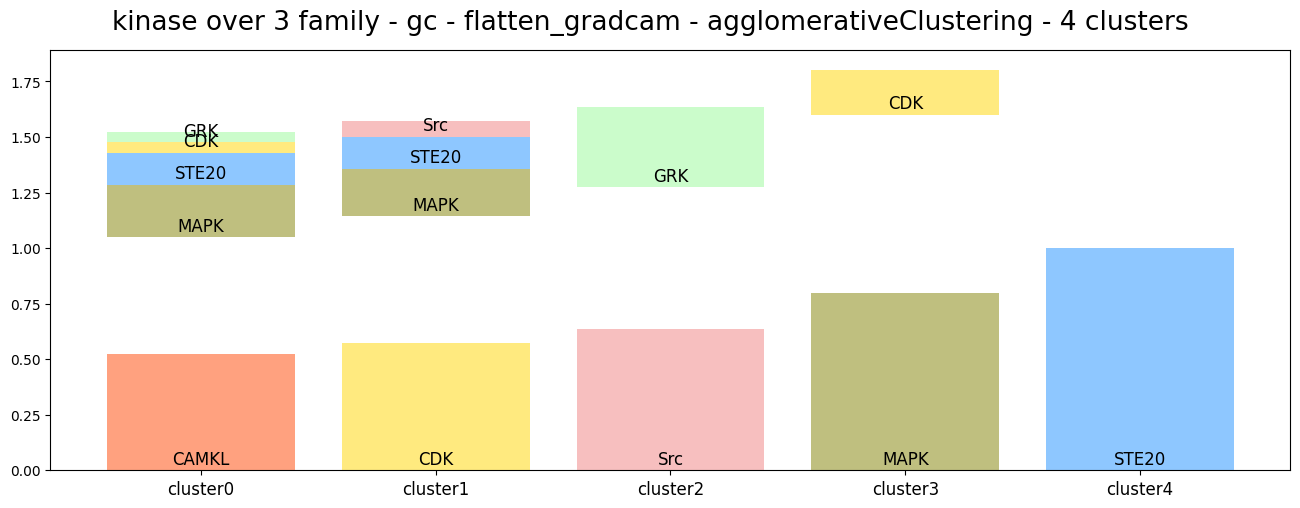

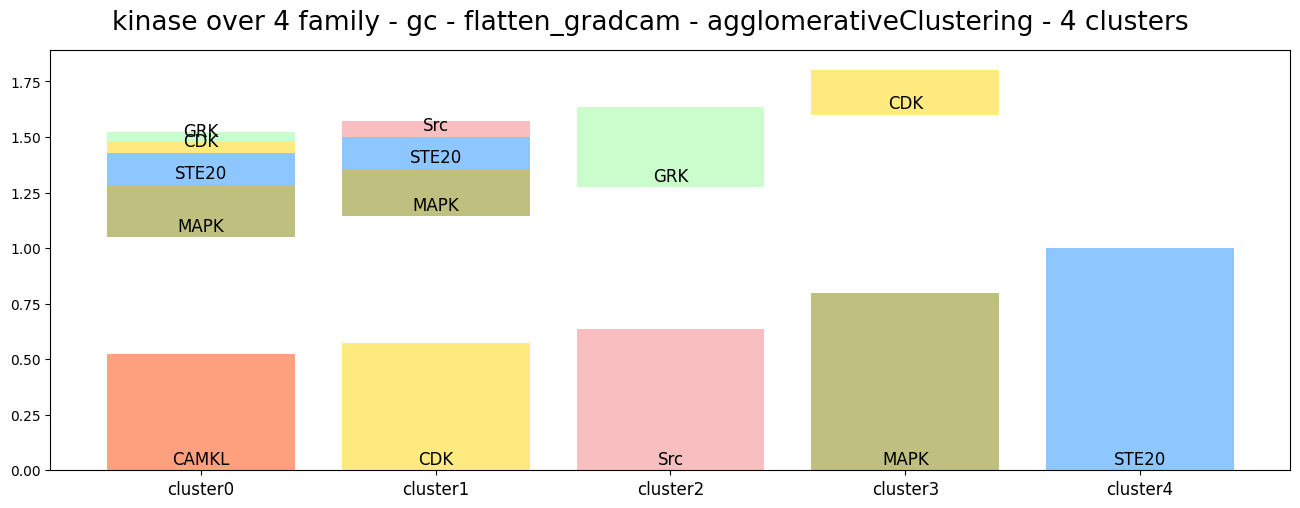

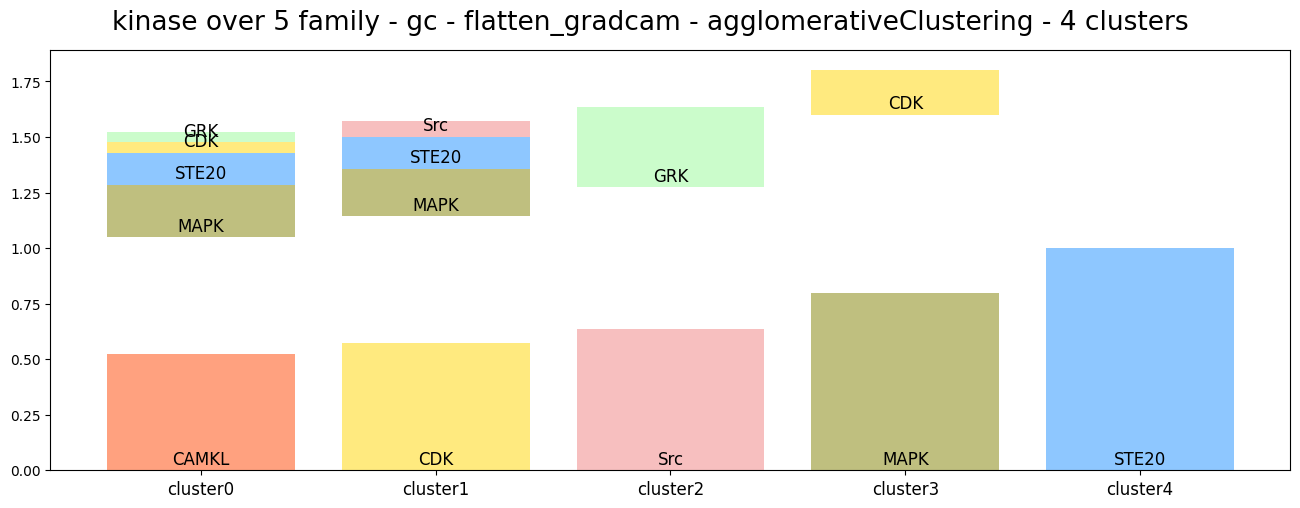

In [24]:
import itertools

for threshold in range(3, 6):
        threshold = str(threshold)
    # try:
        method = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
        plotting(threshold, 'flatten_gradcam', method)
    # except:
        

In [15]:
def plotting(threshold, base_column, method):
    cormatrix = total_corr_matrix_dict[threshold][base_column]
    distance_matrix = 1 - cormatrix
    # _method = method(n_clusters=4, affinity='euclidean', linkage='average')
    # KMeans(n_clusters=6, random_state=0)
    method.fit(distance_matrix)

    labels = method.labels_
    labels

    distance_matrix['cluster'] = labels
    distance_matrix['family'] = [famdict[x] for x in distance_matrix.index]
    distance_matrix
    cluster_family_dict_ = {f'cluster{x}': list(distance_matrix[distance_matrix['cluster']==x].family) for x in range(len(set(labels)))}
    # print(cluster_family_dict_)

    color_dict = dict(zip(set(distance_matrix.family.values), color_list[:len(set(distance_matrix.family.values))]))

    fig, ax = plt.subplots(1, 1, figsize=(16, 5))

    fig.suptitle(f"kinase over {threshold} family - gc - {base_column} - agglomerativeClustering - 4 clusters", fontsize=19, va='bottom')
    fig.subplots_adjust(top=0.95)
    ax.set_xticks(np.arange(len(cluster_family_dict_.keys())))
    ax.set_xticklabels([x for x in cluster_family_dict_.keys()], fontsize=12)
    for idx, _cluster in enumerate([x for x in cluster_family_dict_.values()]):
            # print(idx)
            # if idx == 1:
                # break
            _cluster.sort()
            cc = Counter(_cluster).most_common()
            for _idx, _content in enumerate(cc):
                _family, _count = _content
        
                if _idx == 0:
                    sum_total = sum([x[1] for x in cc]) # 전체 개수, 예: [('Src', 6), ('CDK', 1)] 일 때 7
                    y = _count/sum_total
                    ax.bar(idx, y, facecolor=color_dict[_family], alpha=0.5)
                    ax.text(idx, 0.01, s=cc[0][0], va='bottom', ha='center', fontsize=12)
                    acc = y
                    # print(y)
                    # print(acc)
                else:
                    y = _count/sum_total
                    ax.bar(idx, height=y, facecolor=color_dict[_family], bottom=acc, alpha=0.5)
                    ax.text(x=idx, y=acc+0.01, va='bottom', s=cc[_idx][0], ha='center', fontsize=12)
                acc = acc + y

{'cluster0': ['Src', 'CDK', 'CDK', 'CDK', 'CDK', 'CDK', 'CDK', 'MAPK', 'STE20', 'CDK', 'STE20', 'MAPK'], 'cluster1': ['CDK', 'CDK', 'CDK', 'CAMKL', 'MAPK', 'MAPK', 'MAPK', 'MAPK', 'CAMKL', 'MAPK', 'MAPK'], 'cluster2': ['CAMKL', 'MAPK', 'MAPK', 'MAPK', 'STE20', 'STE20', 'STE20', 'STE20', 'GRK'], 'cluster3': ['GRK', 'GRK', 'GRK', 'GRK', 'Src'], 'cluster4': ['CAMKL', 'CAMKL', 'CAMKL', 'CAMKL', 'CAMKL', 'STE20', 'STE20', 'STE20', 'CAMKL', 'CAMKL', 'CAMKL', 'MAPK'], 'cluster5': ['Src', 'Src', 'Src', 'Src', 'Src', 'Src']}


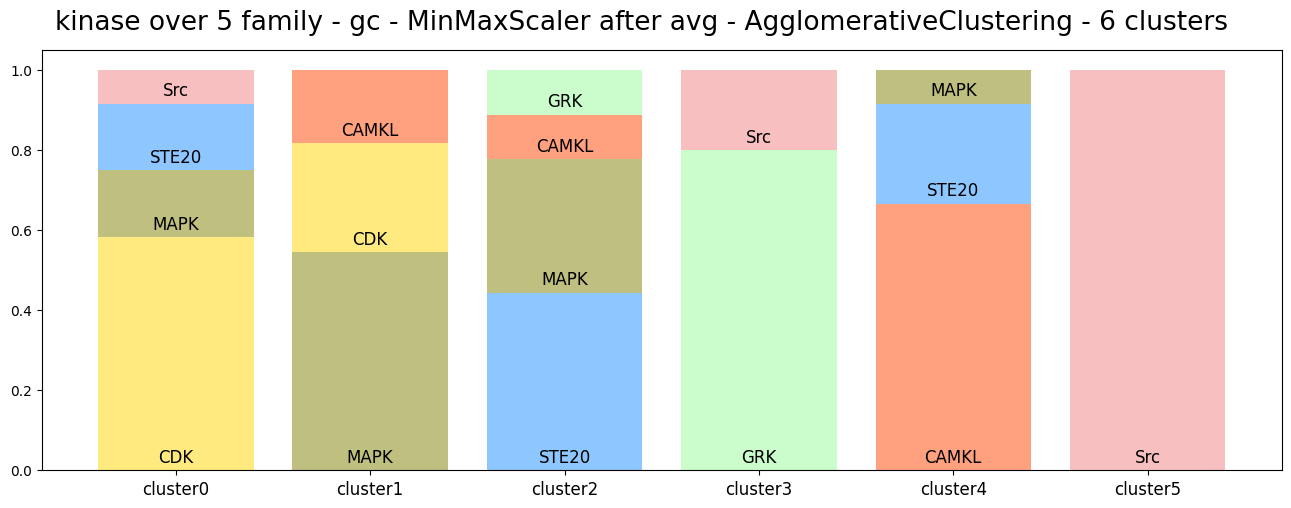

In [96]:
threshold, base_column, num_cluster = '5', 'avg_gradcam_mm_aavg', 6

cormatrix = total_corr_matrix_dict[threshold][base_column]
distance_matrix = 1 - cormatrix
# method = SpectralClustering(n_clusters=num_cluster, n_init=10, random_state=0, n_jobs=64)
method = AgglomerativeClustering(n_clusters=num_cluster, affinity='euclidean', linkage='ward')
# SpectralClustering(n_clusters=i, n_init=10, random_state=0, n_jobs=64)
# method = KMeans(n_clusters=6, random_state=0)
method.fit(distance_matrix)

labels = method.labels_
distance_matrix['cluster'] = labels
distance_matrix['family'] = [famdict[x] for x in distance_matrix.index]
cluster_family_dict_ = {f'cluster{x}': list(distance_matrix[distance_matrix['cluster']==x].family) for x in range(len(set(labels)))}
print(cluster_family_dict_)

color_dict = dict(zip(set(distance_matrix.family.values), color_list[:len(set(distance_matrix.family.values))]))
color_dict

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
if base_column == 'flatten_gradcam':
     _column = 'Norm(X)'
elif base_column == 'avg_gradcam_sd_aavg':
     _column = 'StandardScaler after avg'
elif base_column == 'avg_gradcam_mm_aavg':
     _column = 'MinMaxScaler after avg'
fig.suptitle(f"kinase over {threshold} family - gc - {_column} - {type(method).__name__} - {num_cluster} clusters", fontsize=19, va='bottom')
fig.subplots_adjust(top=0.95)
ax.set_xticks(np.arange(len(cluster_family_dict_.keys())))
ax.set_xticklabels([x for x in cluster_family_dict_.keys()], fontsize=12)
for idx, _cluster in enumerate([x for x in cluster_family_dict_.values()]):
        # print(idx)
        # if idx == 1:
            # break
        _cluster.sort()
        cc = Counter(_cluster).most_common()
        for _idx, _content in enumerate(cc):
            _family, _count = _content
    
            if _idx == 0:
                sum_total = sum([x[1] for x in cc]) # 전체 개수, 예: [('Src', 6), ('CDK', 1)] 일 때 7
                y = _count/sum_total
                ax.bar(idx, y, facecolor=color_dict[_family], alpha=0.5)
                ax.text(idx, 0.01, s=cc[0][0], va='bottom', ha='center', fontsize=12)
                acc = y
                # print(y)
                # print(acc)
            else:
                y = _count/sum_total
                ax.bar(idx, height=y, facecolor=color_dict[_family], bottom=acc, alpha=0.5)
                ax.text(x=idx, y=acc+0.01, va='bottom', s=cc[_idx][0], ha='center', fontsize=12)
                acc = acc + y

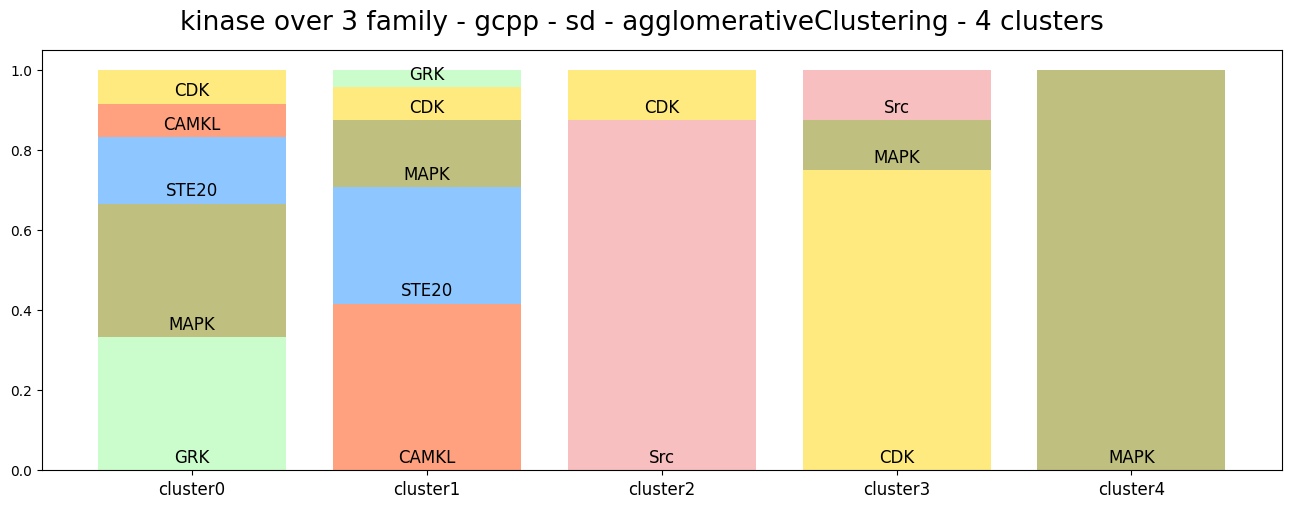

In [26]:
color_dict = dict(zip(set(distance_matrix.family.values), color_list[:len(set(distance_matrix.family.values))]))
color_dict

fig, ax = plt.subplots(1, 1, figsize=(16, 5))

fig.suptitle("kinase over 3 family - gcpp - sd - agglomerativeClustering - 4 clusters", fontsize=19, va='bottom')
fig.subplots_adjust(top=0.95)
ax.set_xticks(np.arange(len(cluster_family_dict_.keys())))
ax.set_xticklabels([x for x in cluster_family_dict_.keys()], fontsize=12)
for idx, _cluster in enumerate([x for x in cluster_family_dict_.values()]):
        # print(idx)
        # if idx == 1:
            # break
        _cluster.sort()
        cc = Counter(_cluster).most_common()
        for _idx, _content in enumerate(cc):
            _family, _count = _content
    
            if _idx == 0:
                sum_total = sum([x[1] for x in cc]) # 전체 개수, 예: [('Src', 6), ('CDK', 1)] 일 때 7
                y = _count/sum_total
                ax.bar(idx, y, facecolor=color_dict[_family], alpha=0.5)
                ax.text(idx, 0.01, s=cc[0][0], va='bottom', ha='center', fontsize=12)
                acc = y
                # print(y)
                # print(acc)
            else:
                y = _count/sum_total
                ax.bar(idx, height=y, facecolor=color_dict[_family], bottom=acc, alpha=0.5)
                ax.text(x=idx, y=acc+0.01, va='bottom', s=cc[_idx][0], ha='center', fontsize=12)
                acc = acc + y

In [68]:
# fig, ax = plt.subplots(1, 1, figsize=(40, 15))

# fig.suptitle("kinase over 3 family - Raw gradcam - KMeans - 6 clusters", fontsize=30, va='bottom')
# fig.subplots_adjust(top=0.95)
# ax.set_xticks(np.arange(len(cluster_family_dict_.keys())))
# ax.set_xticklabels([x for x in cluster_family_dict_.keys()], fontsize=15)
# for idx, _cluster in enumerate([x for x in cluster_family_dict_.values()]):
#         # print(idx)
#         _cluster.sort()
#         cc = Counter(_cluster).most_common()
#         for i, value in enumerate(cc):
#             if i == 0:
 
#                 sum_total = sum([x[1] for x in cc])
#                 total = sum_total
#                 ax.bar(idx, 1, facecolor=color_dict[value[0]], alpha=1)
#                 ax.text(idx, 0.01, s=cc[0][0], va='bottom', ha='center', fontsize=15)
#             else:
#                 i = len(cc)-i

#                 total = total - cc[i][1]
#                 ax.bar(idx, 1/sum_total*total, facecolor=color_dict[value[0]], alpha=1)
#                 ax.text(x=idx, y=1/sum_total*total+0.01, va='bottom', s=cc[i][0], ha='center', fontsize=15)

In [ ]:
clustering_result.to_csv("0629_clustering_result.csv")